In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

In [4]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths (modify these according to your dataset location)
base_dir = r"C:\Users\Digital Experience\Downloads\chest_xray"  # Change this to your dataset path
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# Verify folder structure
def verify_folder_structure(directory):
    print(f"\nContents of {directory}:")
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files[:3]:  # Print first 3 files only
            print(f"{subindent}{f}")
        if len(files) > 3:
            print(f"{subindent}... and {len(files)-3} more files")

verify_folder_structure(train_dir)
verify_folder_structure(test_dir)
verify_folder_structure(val_dir)

Using device: cuda

Contents of C:\Users\Digital Experience\Downloads\chest_xray\train:
train/
    NORMAL/
        IM-0115-0001.jpeg
        IM-0117-0001.jpeg
        IM-0119-0001.jpeg
        ... and 1338 more files
    PNEUMONIA/
        person1000_bacteria_2931.jpeg
        person1000_virus_1681.jpeg
        person1001_bacteria_2932.jpeg
        ... and 3872 more files

Contents of C:\Users\Digital Experience\Downloads\chest_xray\test:
test/
    NORMAL/
        IM-0001-0001.jpeg
        IM-0003-0001.jpeg
        IM-0005-0001.jpeg
        ... and 231 more files
    PNEUMONIA/
        person100_bacteria_475.jpeg
        person100_bacteria_477.jpeg
        person100_bacteria_478.jpeg
        ... and 387 more files

Contents of C:\Users\Digital Experience\Downloads\chest_xray\val:
val/
    NORMAL/
        NORMAL2-IM-1427-0001.jpeg
        NORMAL2-IM-1430-0001.jpeg
        NORMAL2-IM-1431-0001.jpeg
        ... and 5 more files
    PNEUMONIA/
        person1946_bacteria_4874.jpeg
        

In [87]:
# Image transformations and augmentations
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))  # New
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transform)

# Print class information
print("\nClass indices:", train_dataset.class_to_idx)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))


Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Number of training samples: 5216
Number of validation samples: 16
Number of test samples: 624


In [90]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# CheXNet implementation (DenseNet121-based)
class CheXNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.densenet = models.densenet121(weights='DenseNet121_Weights.IMAGENET1K_V1')
        
        # Freeze early layers only (partial unfreezing)
        for i, param in enumerate(self.densenet.parameters()):
            if i < 100:  # Freeze first 100 layers
                param.requires_grad = False
        
        # Enhanced classifier head
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),  # Changed from ReLU
            nn.Dropout(0.6),  # Increased from 0.5
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.densenet(x)

# Initialize the model
model = CheXNet().to(device)

# Define loss function and optimizer
# Calculate class weights
normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
pos_weight = torch.tensor([normal_count/pneumonia_count]).to(device)

# Modify loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # AdamW with decoupled weight decay

# Add gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,
    max_lr=1e-3,
    step_size_up=len(train_loader)*5,  # 5 epochs up
    cycle_momentum=False,
    mode='exp_range',
    gamma=0.999
)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    best_val_auc = 0.0
    best_val_loss = float('inf')
    best_epoch = 0
    patience = 7
    no_improve = 0
    warmup_epochs = 5
    min_delta = 0.002
    
    # Track metrics more robustly
    val_loss_history = []
    val_auc_history = []
    smoothing_window = 5  # Increased from 3
    
    # For plateau detection
    plateau_threshold = 0.005
    plateau_count = 0
    
    history = {
        'train_loss': [], 'val_loss': [], 
        'train_acc': [], 'val_acc': [], 
        'val_auc': [], 'lr': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate training statistics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        
        val_loss, val_acc, val_auc = evaluate_model(model, val_loader, criterion)
        
        # Calculate smoothed metrics with larger window
        val_loss_history.append(val_loss)
        val_auc_history.append(val_auc)
        if len(val_loss_history) > smoothing_window:
            val_loss_history.pop(0)
            val_auc_history.pop(0)
            
        smoothed_val_loss = np.mean(val_loss_history)
        smoothed_val_auc = np.mean(val_auc_history)
        
        # More stringent improvement conditions
        auc_improved = smoothed_val_auc > best_val_auc + min_delta
        loss_improved = smoothed_val_loss < best_val_loss - min_delta
        
        # Only save if both metrics show real improvement
        significant_improvement = (
            (auc_improved and loss_improved) or
            (auc_improved and smoothed_val_loss < best_val_loss + min_delta/2) or
            (loss_improved and smoothed_val_auc > best_val_auc - min_delta/2)
        )
        
        # Plateau detection
        loss_plateau = abs(smoothed_val_loss - best_val_loss) < plateau_threshold
        auc_plateau = abs(smoothed_val_auc - best_val_auc) < plateau_threshold

        # Update LR scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        history['lr'].append(current_lr)
        
        # Print epoch stats
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'LR: {current_lr:.6f}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')
        
        if epoch >= warmup_epochs:
            if significant_improvement:
                best_val_auc = smoothed_val_auc
                best_val_loss = smoothed_val_loss
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_chexnet_model.pth')
                no_improve = 0
                plateau_count = 0
                print(f'Significant improvement at epoch {epoch+1}: '
                      f'ΔAUC {smoothed_val_auc-best_val_auc:.4f}, '
                      f'ΔLoss {best_val_loss-smoothed_val_loss:.4f}')
            else:
                no_improve += 1
                if loss_plateau and auc_plateau:
                    plateau_count += 1
                else:
                    plateau_count = 0
                
            # Enhanced stopping condition
            stop_condition = (
                (no_improve >= patience) or
                (plateau_count >= 3)  # 3 epochs of flat metrics
            )
            
            if stop_condition and epoch > warmup_epochs + 5:  # Minimum 10 epochs
                print(f'\nTraining complete: Plateau reached at epoch {epoch+1}')
                print(f'Best model: epoch {best_epoch+1}, '
                      f'Val AUC: {best_val_auc:.4f}, '
                      f'Val Loss: {best_val_loss:.4f}')
                model.load_state_dict(torch.load('best_chexnet_model.pth'))
                break
        else:
            # Warmup period - simpler saving
            if val_auc > best_val_auc or (val_auc == best_val_auc and val_loss < best_val_loss):
                best_val_auc = val_auc
                best_val_loss = val_loss
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_chexnet_model.pth')
    
    return history

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
    
    # Calculate metrics
    loss = running_loss / len(data_loader.dataset)
    acc = correct / total
    
    # Calculate AUC
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(all_labels, all_probs)
    
    return loss, acc, auc

In [91]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)


Epoch [1/30], LR: 0.000012, Train Loss: 0.3494, Train Acc: 0.6936, Val Loss: 0.4924, Val Acc: 0.6250, Val AUC: 0.8906
Epoch [2/30], LR: 0.000015, Train Loss: 0.3055, Train Acc: 0.8135, Val Loss: 0.4607, Val Acc: 0.6875, Val AUC: 0.9688
Epoch [3/30], LR: 0.000017, Train Loss: 0.2902, Train Acc: 0.8455, Val Loss: 0.4508, Val Acc: 0.8750, Val AUC: 0.9688
Epoch [4/30], LR: 0.000020, Train Loss: 0.2823, Train Acc: 0.8846, Val Loss: 0.4428, Val Acc: 0.8750, Val AUC: 0.9688
Epoch [5/30], LR: 0.000022, Train Loss: 0.2778, Train Acc: 0.9141, Val Loss: 0.4399, Val Acc: 0.8750, Val AUC: 0.9688
Epoch [6/30], LR: 0.000024, Train Loss: 0.2748, Train Acc: 0.9287, Val Loss: 0.4551, Val Acc: 0.9375, Val AUC: 1.0000
Epoch [7/30], LR: 0.000027, Train Loss: 0.2739, Train Acc: 0.9335, Val Loss: 0.4366, Val Acc: 1.0000, Val AUC: 1.0000
Epoch [8/30], LR: 0.000029, Train Loss: 0.2716, Train Acc: 0.9417, Val Loss: 0.4229, Val Acc: 1.0000, Val AUC: 1.0000
Significant improvement at epoch 8: ΔAUC 0.0000, ΔLoss 0

In [92]:
# Load the best model
model.load_state_dict(torch.load('best_chexnet_model.pth'))
model.eval()

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_auc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluating on test set...
Test Loss: 0.3505
Test Accuracy: 0.9359
Test AUC: 0.9791


In [93]:
# Generate predictions and true labels
def get_predictions(model, data_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = (outputs > 0.5).float()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    return all_labels, all_preds

test_labels, test_preds = get_predictions(model, test_loader)

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['NORMAL', 'PNEUMONIA']))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.92      0.91       234
   PNEUMONIA       0.95      0.95      0.95       390

    accuracy                           0.94       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



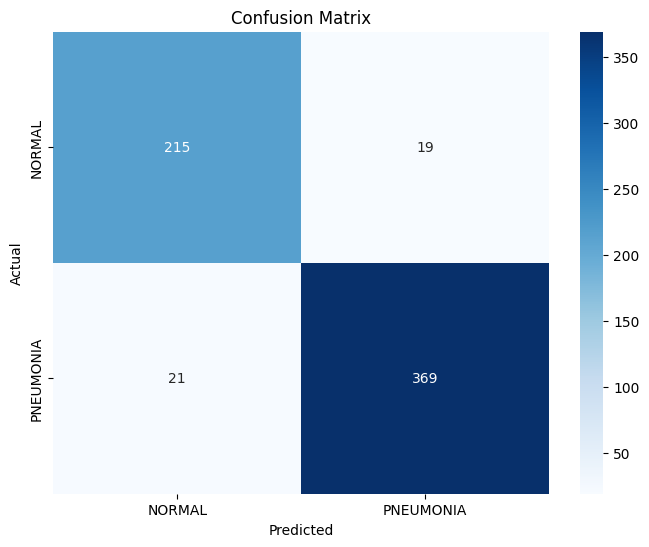

In [94]:
# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NORMAL', 'PNEUMONIA'], 
            yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

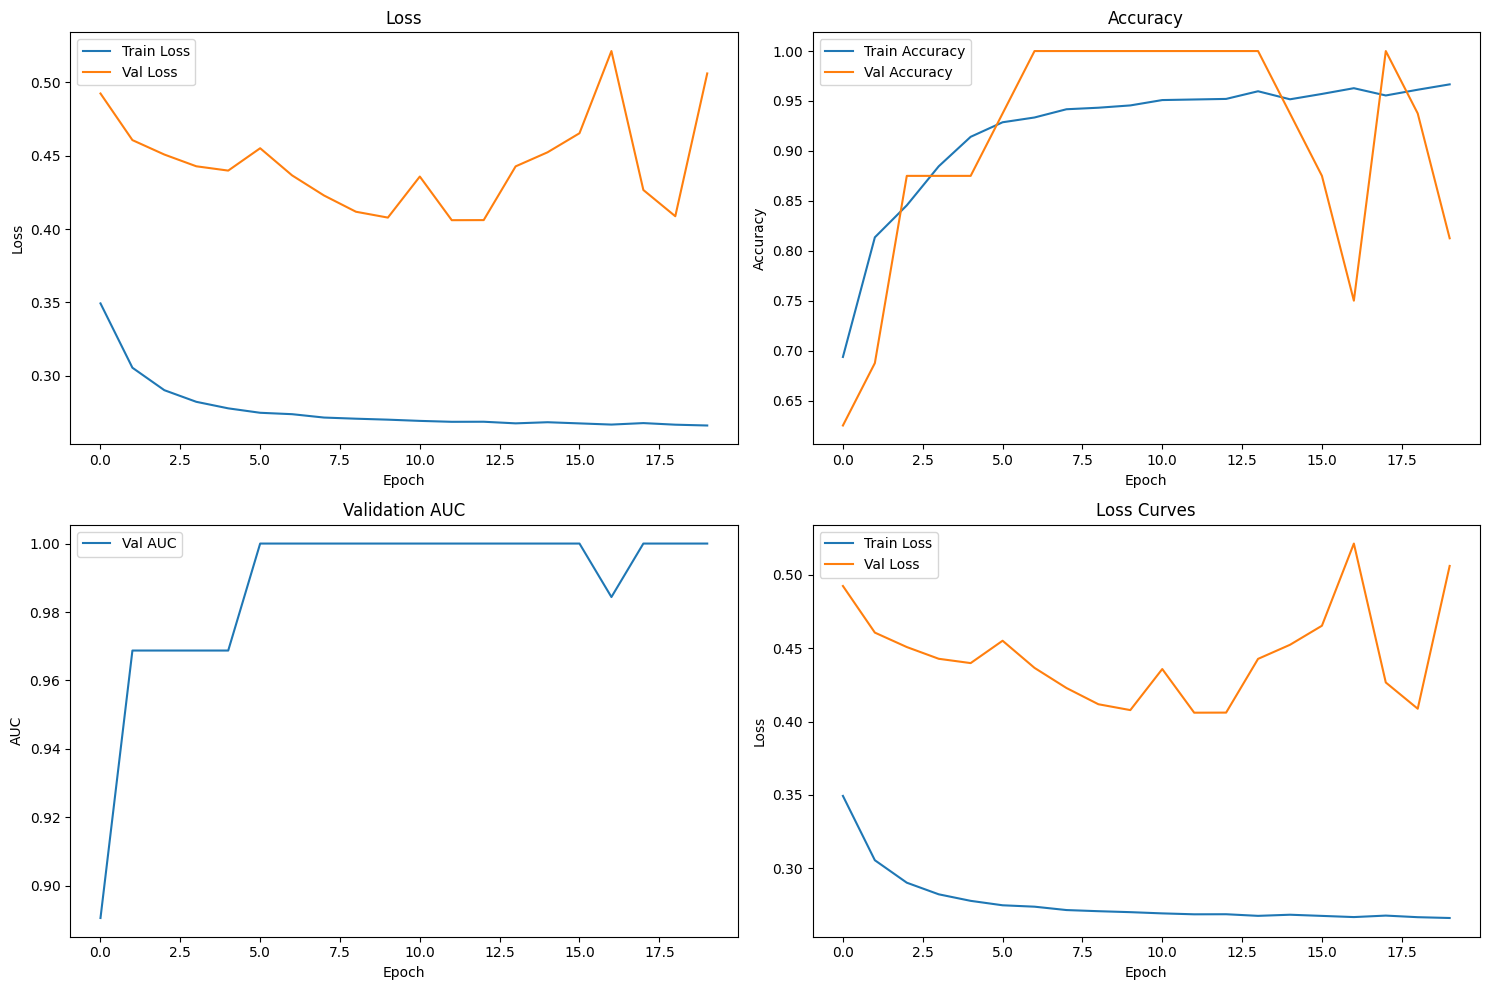

In [95]:
# Plot training history
def plot_history(history):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    axs[0, 0].plot(history['train_loss'], label='Train Loss')
    axs[0, 0].plot(history['val_loss'], label='Val Loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    # Plot accuracy
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy')
    axs[0, 1].plot(history['val_acc'], label='Val Accuracy')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    
    # Plot AUC
    axs[1, 0].plot(history['val_auc'], label='Val AUC')
    axs[1, 0].set_title('Validation AUC')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('AUC')
    axs[1, 0].legend()
    
    # Plot learning rate
    axs[1, 1].plot(history['train_loss'], label='Train Loss')
    axs[1, 1].plot(history['val_loss'], label='Val Loss')
    axs[1, 1].set_title('Loss Curves')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)


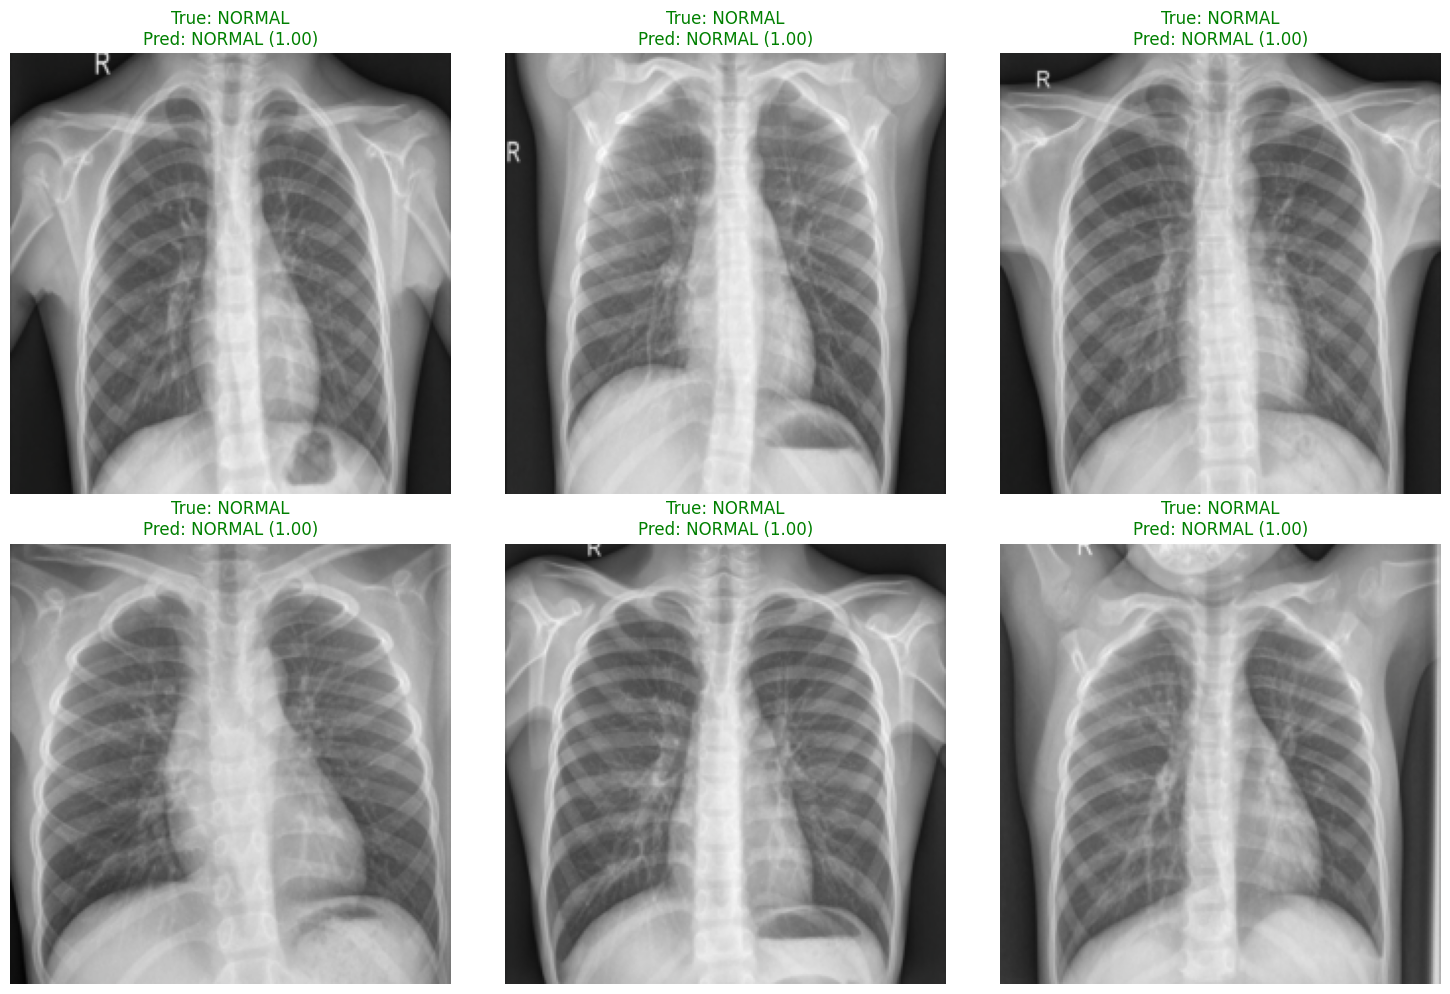

In [99]:
# Function to visualize predictions
def visualize_predictions(model, data_loader, num_images=6):
    model.eval()
    images, labels = next(iter(data_loader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images[:num_images])
        preds = (outputs > 0.5).float()
    
    # Convert images back to displayable format
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        img = inv_normalize(images[i]).cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        
        true_label = 'NORMAL' if labels[i] == 0 else 'PNEUMONIA'
        pred_label = 'NORMAL' if preds[i] == 0 else 'PNEUMONIA'
        confidence = outputs[i].item() if preds[i] == 1 else 1 - outputs[i].item()
        
        title = f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})"
        color = 'green' if true_label == pred_label else 'red'
        plt.title(title, color=color)
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)



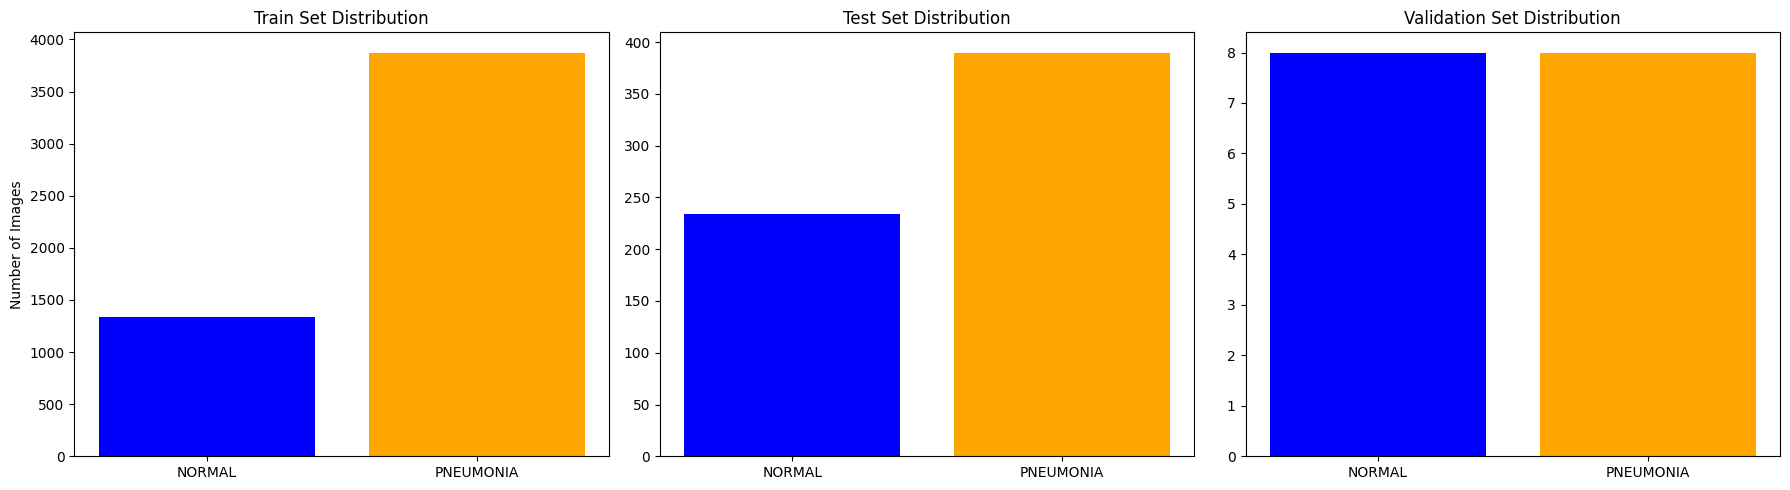

In [97]:
# Additional: Plot class distribution
def plot_class_distribution():
    train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
    train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
    test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
    test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
    val_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
    val_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Train distribution
    axs[0].bar(['NORMAL', 'PNEUMONIA'], [train_normal, train_pneumonia], color=['blue', 'orange'])
    axs[0].set_title('Train Set Distribution')
    axs[0].set_ylabel('Number of Images')
    
    # Test distribution
    axs[1].bar(['NORMAL', 'PNEUMONIA'], [test_normal, test_pneumonia], color=['blue', 'orange'])
    axs[1].set_title('Test Set Distribution')
    
    # Val distribution
    axs[2].bar(['NORMAL', 'PNEUMONIA'], [val_normal, val_pneumonia], color=['blue', 'orange'])
    axs[2].set_title('Validation Set Distribution')
    
    plt.tight_layout()
    plt.show()

plot_class_distribution()